# MPI Assignments

### Exercise 1: Hello World
1. Write an MPI program which prints the message "Hello World"
2. Modify your program so that each process prints out both its rank and the total number of processes P that the code is running on, i.e. the size of `MPI_COMM_WORLD`.
3. Modify your program so that only a single controller process (e.g. rank 0) prints out a message (very useful when you run with hundreds of processes).
4. What happens if you omit the final MPI procedure call in your program?

In [5]:
 %%file hello.py
from mpi4py import MPI
COMM = MPI.COMM_WORLD
nbOfproc = COMM.Get_size()
RANK = COMM.Get_rank()

print("Hello from the rank {} process".format(RANK))
if RANK==nbOfproc-1:
    print("Parallel execution of hello_world with {} process".format(nbOfproc))

Overwriting hello.py


In [12]:
# enter command for compile and run the program
!mpirun -n 4 python3 hello.py

'mpirun' n'est pas reconnu en tant que commande interne
ou externe, un programme ex‚cutable ou un fichier de commandes.


### Exercise 2: Sharing Data
Create a program that obtains an integer input from the terminal and distributes it to all the MPI processes.
Each process must display its rank and the received value. 
Keep reading values until a negative integer is entered.
**Output Example**
```shell
10
Process 0 got 10
Process 1 got 10
```

In [6]:
 %%file sharing.py
 # write your program here
from mpi4py import MPI
COMM = MPI.COMM_WORLD
RANK = COMM.Get_rank()
SIZE = COMM.Get_size()
while True:
    if RANK == 0:
        sendbuf = int(input())
    else: 
        sendbuf = None    
    recv = COMM.bcast(sendbuf, root = 0)    
    print('Process {RANK} got {data}'.format(RANK = RANK, data = recv))   
    if recv < 0: break

Overwriting sharing.py


### Exercise 3 Sending in a ring (broadcast by ring)

Write a program that takes data from process zero and sends it to all of the other processes by sending it in a ring. That is, process i should receive the data add the rank of the process to it then send it to process i+1, until the last process is reached.
Assume that the data consists of a single integer. Process zero reads the data from the user.
print the process rank and the value received.


![ring](../data/ring.gif)

You may want to use these MPI routines in your solution:
`Send` `Recv` 

In [7]:
%%file ring.py
from mpi4py import MPI
COMM = MPI.COMM_WORLD
RANK = COMM.Get_rank()
SIZE = COMM.Get_size()
tag = 100
if RANK == 0:
    sendbuf = int(input())    
    COMM.send(sendbuf, dest = RANK + 1, tag = tag)
else:
    recvbuf = COMM.recv(source = RANK - 1, tag = tag)
    print('I, process',RANK,',I received',recvbuf,'from the process',RANK-1)
    if RANK != SIZE - 1:
        COMM.send(recvbuf,dest = (RANK + 1)%SIZE, tag = tag)   

Overwriting sending.py


In [ ]:
# enter command for compile and run the program
!mpirun -n 4 python3 ring.py



### Exercise 4: Scattering Matrix
1. Create an n by m matrix A on processor 0.
2. Use MPI_Scatterv to send parts of the matrix to the other processors.
3. Processor 1 receives A(i,j) for i=0 to (n/2)-1 and j=m/2 to m-1.
4. Processor 2 receives A(i,j) for i=n/2 to n-1 and j=0 to (m/2)-1.
5. Processor 3 receives A(i,j) for i=n/2 to n-1 and j=m/2 to m-1.
**Example:** using n=m=8 for simplicity.

![N2utM.png](attachment:N2utM.png)



In [ ]:
from mpi4py import MPI
import numpy as np

comm = MPI.COMM_WORLD
rank = comm.Get_rank()
size = comm.Get_size()

n = 8
m = 8
A = np.zeros((n, m))

# Calculate the subarray sizes and displacements
sendcounts = np.zeros(size, dtype=np.int)
displs = np.zeros(size, dtype=np.int)
istart = 0
jstart = 0
for i in range(size):
    sendcounts[i] = ((n//2)+(n%2))*(m//2+(m%2))
    displs[i] = istart*m + jstart
    istart += (n//2)+(n%2)
    if (i+1) % 2 == 0:
        jstart += (m//2)+(m%2)
        istart = 0

# Scatter the matrix A to the other processors
recvbuf = np.empty(sendcounts[rank], dtype=np.float)
comm.Scatterv([A, sendcounts, displs, MPI.DOUBLE], recvbuf, root=0)

# Perform the local computation
iend = istart + (n//2) + (n%2)
jend = jstart + (m//2) + (m%2)
if rank == 1:
    # Processor 1 computes A(i,j) for i=0 to (n/2)-1 and j=m/2 to m-1
    for i in range(n//2):
        for j in range(m//2, m):
            A[i,j] = some_computation()
elif rank == 2:
    # Processor 2 computes A(i,j) for i=n/2 to n-1 and j=0 to (m/2)-1
    for i in range(n//2, n):
        for j in range(m//2):
            A[i,j] = some_computation()
elif rank == 3:
    # Processor 3 computes A(i,j) for i=n/2 to n-1 and j=m/2 to m-1
    for i in range(n//2, n):
        for j in range(m//2, m):
            A[i,j] = some_computation()

# Gather the results back to processor 0
comm.Gatherv(recvbuf, [A, sendcounts, displs, MPI.DOUBLE], root=0)

if rank == 0:
    print(A)

MPI.Finalize()


### Exercise 5 Matrix vector product

1. Use the `MatrixVectorMult.py` file to implement the MPI version of matrix vector multiplication.
2. Process 0 compares the result with the `dot` product.
3. Plot the scalability of your implementation. 

**Output Example**
```shell
CPU time of parallel multiplication using 2 processes is  174.923446
The error comparing to the dot product is : 1.4210854715202004e-14
```


In [8]:
 %%file MatrixVectorMult_V0.py
 # write your program here
import time 
import numpy as np
from scipy.sparse import lil_matrix
from numpy.random import rand, seed
from numba import njit
from mpi4py import MPI


''' This program compute parallel csc matrix vector multiplication using mpi '''

COMM = MPI.COMM_WORLD
nbOfproc = COMM.Get_size()
RANK = COMM.Get_rank()

seed(42)

def matrixVectorMult(A, b, x):
    
    row, col = A.shape
    for i in range(row):
        a = A[i]
        for j in range(col):
            x[i] += a[j] * b[j]

    return 0

########################initialize matrix A and vector b ######################
#matrix sizes
SIZE = 1000
Local_size = SIZE // nbOfproc


# counts = block of each proc
proc_block = Local_size * SIZE
counts =  [proc_block for i in range(nbOfproc)]

if RANK == 0:
    A = lil_matrix((SIZE, SIZE))
    A[0, :100] = rand(100)
    A[1, 100:200] = A[0, :100]
    A.setdiag(rand(SIZE))
    A = A.toarray()
    b = rand(SIZE)
else :
    A = None
    b = None



#########Send b to all procs and scatter A (each proc has its own local matrix#####
LocalMatrix = np.empty((Local_size, SIZE), dtype = np.float64)
b = COMM.bcast(b, root = 0)
# Scatter the matrix A
COMM.Scatterv([A, counts, MPI.DOUBLE], LocalMatrix, root = 0)
#####################Compute A*b locally#######################################
LocalX = np.zeros(Local_size)
start = MPI.Wtime()
matrixVectorMult(LocalMatrix, b, LocalX)
stop = MPI.Wtime()
if RANK == 0:
    print("CPU time of parallel multiplication using", nbOfproc,"processes is ", (stop - start)*1000)


##################Gather te results ###########################################
# sendcouns = local size of result
sendcounts = [Local_size for i in range(nbOfproc)] 
if RANK == 0: 
    X = np.empty(SIZE, dtype = np.float64)
else :
    X = None

# Gather the result into X
COMM.Gatherv(LocalX,[X, sendcounts, MPI.DOUBLE], root = 0)

##################Print the results ###########################################

if RANK == 0 :
    X_ = A.dot(b)
    print("The error comparing to the dot product is :", np.max(X_ - X))

Overwriting MatrixVectorMult_V0.py


In [ ]:
# enter command for compile and run the program
!mpirun -n 2 python3 MatrixVectorMult_V0.py

Text(0.5, 1.0, 'CPU time per number of processes use to the product Matrix vect')

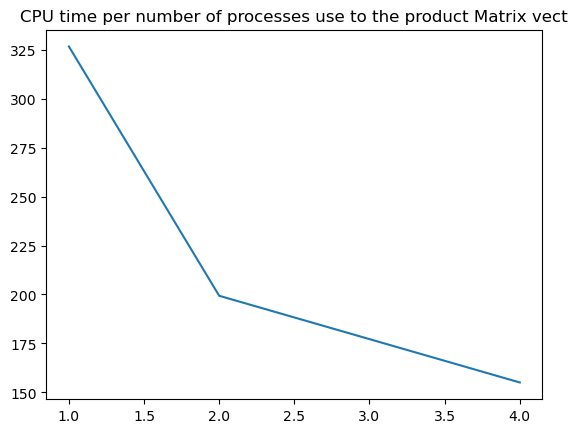

In [9]:
import matplotlib.pyplot as plt
CPU_time=[326.5986, 199.3336, 155.07819]
plt.plot([1,2,4],CPU_time)
plt.title("CPU time per number of processes use to the product Matrix vect")

### Exercise 6: Pi calculation
An approximation to the value π can be obtained from the following expression

![Pi expression](../data/pi.PNG)

where the answer becomes more accurate with increasing N. Iterations over i are independent so the
calculation can be parallelized.

For the following exercises you should set N = 840. This number is divisible by 2, 3, 4, 5, 6, 7 and 8
which is convenient when you parallelize the calculation!

1. Create a program where each process independently computes the value of `π` and prints it to the screen. Check that the values are correct (each process should print the same value)
2. Now arrange for different processes to do the computation for different ranges of i. For example, on two processes: rank 0 would do i = 0, 1, 2, . . . , N/2 - 1; rank 1 would do i = N/2, N/2 + 1, . . . , N-1.
Print the partial sums to the screen and check the values are correct by adding them up by hand.
3. Now we want to accumulate these partial sums by sending them to the controller (e.g. rank 0) to add up:
- all processes (except the controller) send their partial sum to the controller
- the controller receives the values from all the other processes, adding them to its own partial sum
1. Use the function `MPI_Wtime` (see below) to record the time it takes to perform the calculation. For a given value of N, does the time decrease as you increase the number of processes? Note that to ensure that the calculation takes a sensible amount of time (e.g. more than a second) you will probably have to perform the calculation of `π` several thousands of times.
2. Ensure your program works correctly if N is not an exact multiple of the number of processes P


In [10]:
 %%file PiMonteCarlo_V0.py

import random 
import timeit
from mpi4py import MPI

COMM = MPI.COMM_WORLD
nbOfproc = COMM.Get_size()
RANK = COMM.Get_rank()



random.seed(42)  

def compute_points(n):
    
    random.seed(42)  
    
    circle_points= 0

    # Total Random numbers generated= possible x 
    # values* possible y values 
    for i in range(n): 
      
        # Randomly generated x and y values from a 
        # uniform distribution 
        # Rannge of x and y values is -1 to 1 
                
        rand_x= random.uniform(-1, 1) 
        rand_y= random.uniform(-1, 1) 
      
        # Distance between (x, y) from the origin 
        origin_dist= rand_x**2 + rand_y**2
      
        # Checking if (x, y) lies inside the circle 
        if origin_dist<= 1: 
            circle_points+= 1
      
        # Estimating value of pi, 
        # pi= 4*(no. of points generated inside the  
        # circle)/ (no. of points generated inside the square) 
    
     
    
    return circle_points

INTERVAL= 1000
a= int((INTERVAL**2)/4)
start = timeit.default_timer()
circle_points = compute_points(a)
end = timeit.default_timer()
pi = 4* circle_points/ INTERVAL**2 
circle_point_reduced = COMM.reduce(circle_points, op=MPI.SUM, root=0)
pi_reduced = COMM.reduce(pi, op=MPI.SUM, root=0)
if RANK==0:
    print("Circle points number :",circle_point_reduced )
    print("Final Estimation of Pi=", pi_reduced, "cpu time :",end-start) 

Overwriting PiMonteCarlo_V0.py


Text(0.5, 1.0, 'CPU time per number of processes use to the Pi MonteCarlo ')

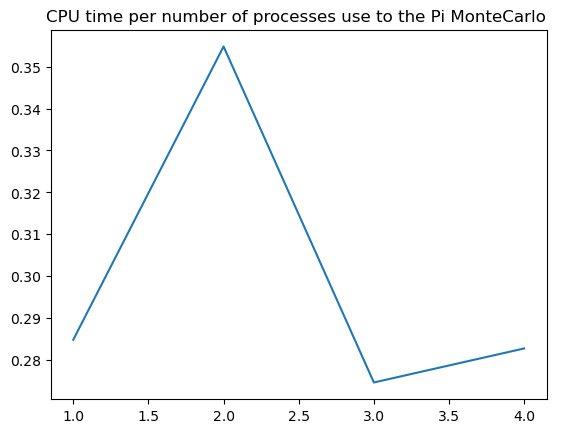

In [11]:
CPU_time=[0.28484, 0.35480, 0.27464, 0.28276]
plt.plot([1, 2, 3, 4],CPU_time)
plt.title("CPU time per number of processes use to the Pi MonteCarlo ")